# Tax assistance
## Module 1 Estimate tax using similarity search. 
### Demonstrates **embeddings and function calling** GenAI capabilities 
**Leverages EmbedContent and GenerateContent models.**


**Setup**
Start by installing and importing the Python SDK.

In [120]:
!pip install -U -q "google-genai==1.7.0"

Import genai modules and print version

In [121]:
from google import genai
from google.genai import types
from IPython.display import Markdown, display

genai.__version__

'1.7.0'

Set up your API key
To run the following cell, your API key must be stored it in a Kaggle secret named GOOGLE_API_KEY.

If you don't already have an API key, you can grab one from AI Studio. You can find detailed instructions in the docs.

To make the key available through Kaggle secrets, choose Secrets from the Add-ons menu and follow the instructions to add your key or enable it for this notebook.

In [122]:
from kaggle_secrets import UserSecretsClient
import os

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

client = genai.Client(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of No user secrets exist for kernel id ..., then you need to add your API key via Add-ons, Secrets and enable it.

Automated Retry

This codelab sends a lot of requests, so set up an automatic retry that ensures your requests are retried when per-minute quota is reached.


In [123]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

Import python modules for data processing

In [124]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

Define a function for creating synthetic data. 
This synthetic dataset simulates individual taxpayer financial profiles for estimating U.S. federal income tax. 
It includes realistic variation in income, deductions, dependents, and filing status.

In [125]:
def generate_tax_dataset(n=50):
    np.random.seed(42)
    
    filing_statuses = ["single", "married_filing_jointly", "head_of_household"]
    
    data = {
        "filing_status": np.random.choice(filing_statuses, size=n),
        "income": np.random.lognormal(mean=11.3, sigma=0.4, size=n).clip(10000, 300000),
        "student_loan_interest": np.random.uniform(0, 3000, size=n),
        "mortgage_interest": np.random.uniform(0, 15000, size=n),
        "charitable_donations": np.random.exponential(scale=1000, size=n).clip(0, 10000),
        "dependents": np.random.choice([0, 1, 2, 3, 4, 5], p=[0.3, 0.25, 0.2, 0.15, 0.08, 0.02], size=n)
    }

    df = pd.DataFrame(data)
    # Round float columns to 2 decimal places
    float_cols = ["income", "student_loan_interest", "mortgage_interest", "charitable_donations"]
    df[float_cols] = df[float_cols].round(2)
    return df

Devise a estmated tax calculator based on 2024 tax brackets, standard deductions and child tax credit

In [126]:
import pandas as pd

def estimate_tax(row, filing_status="single"):
    income = row["income"]
    mortgage_interest = row.get("mortgage_interest", 0)
    student_loan_interest = row.get("student_loan_interest", 0)
    charitable_donations = row.get("charitable_donations", 0)
    dependents = row.get("dependents", 0)

    child_tax_credit = 2000
    deductions = {
        "single": 13850,
        "married_filing_jointly": 27700,
        "head_of_household": 20800,
    }

    brackets = {
        "single": [
            (0, 11600, 0.10),
            (11601, 47150, 0.12),
            (47151, 100525, 0.22),
            (100526, 191950, 0.24),
            (191951, 243725, 0.32),
            (243726, 609350, 0.35),
            (609351, None, 0.37)
        ],
        "married_filing_jointly": [
            (0, 23200, 0.10),
            (23201, 94300, 0.12),
            (94301, 201050, 0.22),
            (201051, 383900, 0.24),
            (383901, 487450, 0.32),
            (487451, 731200, 0.35),
            (731201, None, 0.37)
        ],
        "head_of_household": [
            (0, 17400, 0.10),
            (17401, 62400, 0.12),
            (62401, 159800, 0.22),
            (159801, 243700, 0.24),
            (243701, 509800, 0.32),
            (509801, 609350, 0.35),
            (609351, None, 0.37)
        ]
    }

    itemized_deductions = mortgage_interest + student_loan_interest + charitable_donations
    deduction_amount = max(deductions[filing_status], itemized_deductions)
    taxable_income = max(0, income - deduction_amount)

    tax = 0
    for lower, upper, rate in brackets[filing_status]:
        if taxable_income > lower:
            upper_bound = taxable_income if upper is None or taxable_income < upper else upper
            tax += (upper_bound - lower) * rate
            if upper is None or taxable_income <= upper:
                break
        else:
            break

    tax_credit = dependents * child_tax_credit
    final_tax = tax - tax_credit

    estimated_tax = max(0, round(final_tax, 2))
    estimated_refund = max(0, round(-final_tax, 2))

    return pd.Series([
        estimated_tax,
        estimated_refund
    ])

Using the tax estimator function add predicted tax and refind columns to the synthetic data set generated earlier.

In [127]:
df_income_tax_return = generate_tax_dataset()
df_income_tax_return[["predicted_tax", "refund"]] = df_income_tax_return.apply(estimate_tax, axis=1)
print(df_income_tax_return)

             filing_status     income  student_loan_interest  \
0        head_of_household   76413.34                 707.95   
1                   single   79755.63                 768.20   
2        head_of_household   59896.26                 121.30   
3        head_of_household   59198.25                2131.99   
4                   single  118129.55                 332.67   
5                   single  152107.11                1318.01   
6        head_of_household   69754.11                 605.16   
7   married_filing_jointly   93922.56                2687.29   
8        head_of_household   50148.14                1426.11   
9        head_of_household   68622.74                1689.83   
10       head_of_household   67595.95                2086.55   
11       head_of_household  148701.56                 417.99   
12                  single   91968.36                1813.25   
13       head_of_household   46287.78                1619.52   
14  married_filing_jointly   33815.22   

Use internet grounding to get latest tax brackets and standard deductions

In [128]:
# Get the tax brackets with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0, # For deterministic output
)

def query_tax_brackets_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="""Create json format for the 2024 tax brackets and return the json with following format. Respond with this json without additional turn
        brackets = {
        "single": [
           (0, 16550, 0.10),
           (0, 16550, 0.10),
           
        "married_filing_jointly": [
            (0, 16550, 0.10),
            (0, 16550,  0.10),
        ],
        "head_of_household": [
            (0, 16550, 0.10),
            (0, 16550, 0.10),
            
        ]
    }""",
        config=config_with_search,
    )
    return response.candidates[0]

rc = query_tax_brackets_with_grounding()
#tax_brackets = json.loads(rc.content.parts[0].text)
print(rc.content.parts[0].text)

def query_std_deductions_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="""Create json format for the 2024 standard deduction amounts and return the json with the following format. Respond with this json without additional turn
        deductions = {
        "single": 13850,
        "married_filing_jointly": 27700,
        "head_of_household": 20800,
    }
   """,
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_std_deductions_with_grounding()
print(rc.content.parts[0].text)
#deductions = json.loads(rc.content.parts[0].text)

```json
{
    "single": [
        {
            "lower_bound": 0,
            "upper_bound": 11600,
            "rate": 0.10
        },
        {
            "lower_bound": 11601,
            "upper_bound": 47150,
            "rate": 0.12
        },
        {
            "lower_bound": 47151,
            "upper_bound": 100525,
            "rate": 0.22
        },
        {
            "lower_bound": 100526,
            "upper_bound": 191950,
            "rate": 0.24
        },
        {
            "lower_bound": 191951,
            "upper_bound": 243725,
            "rate": 0.32
        },
        {
            "lower_bound": 243726,
            "upper_bound": 609350,
            "rate": 0.35
        },
        {
            "lower_bound": 609351,
            "upper_bound": null,
            "rate": 0.37
        }
    ],
    "married_filing_jointly": [
        {
            "lower_bound": 0,
            "upper_bound": 23200,
            "rate": 0.10
        },
        {
            "lo

Explore available models for embedding content


In [129]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for model in client.models.list():
  if 'embedContent' in model.supported_actions:
    print(model.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [130]:
# Convert each row into a string for embedding
texts = df_income_tax_return.apply(lambda row: f"{row['filing_status']} {row['income']} {row['student_loan_interest']} {row['mortgage_interest']} {row['charitable_donations']} {row['dependents']} {row['predicted_tax']} {row['refund']}", axis=1).tolist()
print(texts)

['head_of_household 76413.34 707.95 2221.3 209.13 2 4816.59 0.0', 'single 79755.63 768.2 14966.11 326.94 4 1065.42 0.0', 'head_of_household 59896.26 121.3 4001.72 1205.17 1 3293.43 0.0', 'head_of_household 59198.25 2131.99 14649.22 1875.11 2 632.91 0.0', 'single 118129.55 332.67 6165.56 1940.2 2 14069.01 0.0', 'single 152107.11 1318.01 495.76 518.37 5 16223.63 0.0', 'head_of_household 69754.11 605.16 5176.07 2187.21 0 7351.56 0.0', 'married_filing_jointly 93922.56 2687.29 9515.27 1903.33 1 10612.33 0.0', 'head_of_household 50148.14 1426.11 10210.58 2743.19 0 4060.07 0.0', 'head_of_household 68622.74 1689.83 7964.02 1538.7 0 7102.66 0.0', 'head_of_household 67595.95 2086.55 6716.75 1105.6 1 4876.77 0.0', 'head_of_household 148701.56 417.99 8293.4 869.14 1 23406.29 0.0', 'single 91968.36 1813.25 8890.45 465.67 1 10238.7 0.0', 'head_of_household 46287.78 1619.52 1212.8 2815.64 3 0.0 2339.59', 'married_filing_jointly 33815.22 609.18 5544.82 3636.81 4 0.0 5836.29', 'single 53233.41 2828.56 

For each row in the dataset embed content using text-embedding-004 model and append to the list embeddings

In [131]:
def embed_texts(texts):
    embeddings = []
    for text in texts:
        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=text,
            config=types.EmbedContentConfig(task_type='semantic_similarity'),
        )
        embeddings.append(response.embeddings[0].values)
    return embeddings

Finally add a column to the dataset called embedding to the dataset with each row's own embedding


In [132]:
# Generate embeddings
df_income_tax_return['embedding'] = embed_texts(texts)
print(df_income_tax_return)

             filing_status     income  student_loan_interest  \
0        head_of_household   76413.34                 707.95   
1                   single   79755.63                 768.20   
2        head_of_household   59896.26                 121.30   
3        head_of_household   59198.25                2131.99   
4                   single  118129.55                 332.67   
5                   single  152107.11                1318.01   
6        head_of_household   69754.11                 605.16   
7   married_filing_jointly   93922.56                2687.29   
8        head_of_household   50148.14                1426.11   
9        head_of_household   68622.74                1689.83   
10       head_of_household   67595.95                2086.55   
11       head_of_household  148701.56                 417.99   
12                  single   91968.36                1813.25   
13       head_of_household   46287.78                1619.52   
14  married_filing_jointly   33815.22   

Devise a function to embed user's query to search for similarity in the dataset created earlier


In [133]:
def embed_query(query):
    response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=query,
        config=types.EmbedContentConfig(task_type='semantic_similarity'),
    )
    return response.embeddings[0].values

Devise a function search_similar     
* Embeds the user query
* Computes cosine similarity against stored embeddings
* Selects the top match(es) ( most similar, n  = 1)
* Returns a DataFrame with selected columns


In [134]:
def search_similar(query, df, top_n=1):
    query_vec = np.array(embed_query(query)).reshape(1, -1)
    embedding_matrix = np.vstack(df['embedding'].to_numpy())
    similarities = cosine_similarity(query_vec, embedding_matrix)[0]
    top_indices = similarities.argsort()[::-1][:top_n]
    top_results = df.iloc[top_indices].copy()
    top_results['similarity'] = similarities[top_indices]
    return top_results[['filing_status', 'income', 'student_loan_interest', 'mortgage_interest','charitable_donations','predicted_tax', 'dependents', 'refund', 'similarity']]


Simple example usage to predict tax based on similarity search
* Create a json structure (without predicted tax, refund amounts)
* Prepare the json for embedding(in the format used earlier for embedding synthetic dataset)
* Find the most similar row - use this row's predicted tax/ refund ammounts as a rough estimated tax for the user query.


In [135]:
def json_to_embedding_format(json):
    # Convert to string format: key: value
    kv_string = ' '.join(f"{value}" for key, value in json.items())
    return kv_string
    
sample_json = '''
            {"filing_status": "single",
            "income": 72000,
            "student_loan_interest": 0,
            "mortgage_interest": 0,
            "charitable_donations": 0,
            "dependents": 0
            }
            '''
query_text = json_to_embedding_format(json.loads(sample_json))
top_matches = search_similar(query_text, df_income_tax_return)
print(top_matches)

   filing_status    income  student_loan_interest  mortgage_interest  \
47        single  78241.26                 740.63           14481.29   

    charitable_donations  predicted_tax  dependents  refund  similarity  
47                634.77        8777.27           0     0.0     0.76609  


Estimate tax using similarity search and function calling 

In [136]:
# Define a function that the model can call to predict taxe on the basis of similarity search
tax_return_declaration = {
    "name": "predict_tax",
    "description": "Predict rought estimated tax due/refund based on similarity search",
    "parameters": {
        "type": "object",
        "properties": {
            "filing_status": {
                "type": "string",
                "enum": ["single", "married_filing_jointly", "head_of_household"],
                "description": "Filing status of the tax payer",
            },
            "income": {
                "type": "integer",
                "description": "Taxable income of the tax payer",
            },
            "student_loan_interest": {
                "type": "integer",
                "description": "Any interested paid on student loan",
            },
            "mortgage_interest": {
                "type": "integer",
                "description": "Home loan mortgage interest paid",
            },
            "charitable_donations": {
                "type": "integer",
                "description": "Any donation made to the charitable institutions",
            },
            "dependents": {
                "type": "integer",
                "description": "Number of dependents",
            }
        },
        "required": ["filing_status", "income","student_loan_interest","mortgage_interest","charitable_donations","dependents"],
    },
}

# This is the actual function that would be called based on the model's suggestion
def predict_tax(filing_status: str, 
                   income: int, 
                   student_loan_interest: int, 
                   mortgage_interest: int,
                   charitable_donations: int,
                   dependents: int) -> dict[int, int, int]:
    """Predict rough estimated tax owed based on similarity search(mock API).

    Args:
            filing_status        : Filing status of the tax payer, default single
            income               : Taxable income of the tax payer, default 0
            student_loan_interest: Any interested paid on student loan,default 0
            mortgage_interest    : Home loan mortgage interest paid, default 0
            charitable_donations : Any donation made to the charitable institutions, default 0
            dependents           : Number of dependents, default 0

    Returns:
        A dictionary containing the predicted tax, refund and similarity score for the nearest matching row from the data set.
    """
    
    json_dict = {"filing_status": filing_status,
            "income": income,
            "student_loan_interest": student_loan_interest,
            "mortgage_interest": mortgage_interest,
            "charitable_donations": charitable_donations,
            "dependents": dependents}
    
    print(json_dict)
    my_query = json_to_embedding_format(json_dict)
    top_matches = search_similar(my_query, df_income_tax_return)
        
    return {"predicted_tax": top_matches['predicted_tax'].iloc[0], "refund": top_matches['refund'].iloc[0], "similarity_match": top_matches['similarity'].iloc[0]}


Define tools, system instruction to be used by model

In [137]:
tax_tools = types.Tool(function_declarations=[tax_return_declaration])

instruction = """You are a helpful tax assistant that can interact with tax prediction function to predict tax.
You will take the users tax information, extract filing status, income, donations, mortgage, student loan, dependents and turn them into a json. 
Default any missing information to 0, filing status to single. Use json structure with these key names and the default values.
{
        "filing_status": "single",
        "income": 0,
        "dependents": 0,
        "mortgage_interest": 0,
        "charitable_donations": 0,
        "student_loan_interest": 0
}
Once you have all the values, Call predict_tax function to predict tax using this information. 
"""
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
         system_instruction= instruction,
         tools=[tax_tools],
    )
)

# User prompt
resp = chat.send_message("My status is single , income of 35000. Estimate my tax")
print(f"Response Text -> {resp.text}") # None if model has no follow up question for the user and function was called

tool_call = resp.candidates[0].content.parts[0].function_call
print(f"Function Call -> {resp.candidates[0].content.parts[0].function_call}") # None if the model needs additional clarification from the user
if tool_call!=None and tool_call.name == "predict_tax":
    result = predict_tax(**tool_call.args)
    print(f"Function execution result: {result}")

Response Text -> None
Function Call -> id=None args={'dependents': 0, 'charitable_donations': 0, 'mortgage_interest': 0, 'income': 35000, 'filing_status': 'single', 'student_loan_interest': 0} name='predict_tax'
{'filing_status': 'single', 'income': 35000, 'student_loan_interest': 0, 'mortgage_interest': 0, 'charitable_donations': 0, 'dependents': 0}
Function execution result: {'predicted_tax': 4882.29, 'refund': 0.0, 'similarity_match': 0.7611661089192165}


## Module 2 Tax Assistant Prompting.
### Demonstrates **few-shot prompting**.

In [138]:
tax_tools = types.Tool(function_declarations=[tax_return_declaration])

instruction = """You are a helpful tax assistant for residents of California that can interact with tax prediction function to predict tax.
You will take the users tax information, extract filing status, income, donations, mortgage, student loan, dependents and turn them into a json. 
Default any missing information to 0, filing status to single. Use json structure with these key names and the default values.
{
        "filing_status": "single",
        "income": 0,
        "dependents": 0,
        "mortgage_interest": 0,
        "charitable_donations": 0,
        "student_loan_interest": 0
}
Once you have all the values, Call predict_tax function to predict tax using this information. Use the answers to give a numerical estimate and a final classification:
- 'Owes Taxes'
- 'Does Not Owe Taxes'

Each prediction must be justified based on user answers and Google Search API data.
---

EXAMPLE 1:
User Answers:
- Filing Status: Single
- Income: $120,000
- Dependents: 0
- Mortgage Interest: 0
- Charitable Donations: 0
- Student Loan Interest: 0
- Claimed Deductions: $5,000  

Google Search API Result: "Californians earning over $100,000 typically owe federal and state taxes."

Prediction: Owes Taxes  
Justification: High income, limited deductions, and California's high state tax burden.

---

EXAMPLE 2:
User Answers:
- Income: $28,000 
- Filing Status: Head of Household
- Dependents: 0
- Mortgage Interest: 0
- Charitable Donations: 0
- Student Loan Interest: 0 
- Claimed Deductions: $18,000  

Google Search API Result: "Low-income with high deductions in California may have zero federal tax liability."

Prediction: Does Not Owe Taxes  
Justification: Low income, high deductions, and favorable filing status.

---

EXAMPLE 3:
User Answers:
- Income: $85,000  
- Filing Status: Single
- Dependents: 0 
- Mortgage Interest: 0
- Charitable Donations: 0
- Student Loan Interest: 0 
- Claimed Deductions: $15,000 (Standard)

Google Search API Result: "Most earners in California at this income level typically owe federal and state taxes."

Prediction: Does Owe Taxes  
Justification: Moderate income and deductions do not eliminate tax liability in California.
 
Lesson: Be cautious not to underpredict.

---

EXAMPLE 4:
User Answers:
- Income: $60,000
- Filing Status: Single
- Dependents: 0
- Mortgage Interest: 0
- Charitable Donations: 0
- Student Loan Interest: 0
- Claimed Deductions: $10,000  
- Other Taxable Income: $12,000 in crypto gains

Google Search API Result: "Crypto income is taxable in California and increases adjusted gross income. A $60k salary plus $12k crypto gains usually results in tax liability, even after deductions."

Prediction: Does Owe Taxes   
Justification: Crypto is taxable. Total income = $72,000. Tax due likely. Be cautious with hidden or misunderstood income sources.

Lesson: Never ignore extra income sources like crypto or dividends, especially in high-tax states like California.

---

EXAMPLE 5:
User Answers:
- Income: $74,000
- Filing Status: Head of Household
- Dependents: 2
- Mortgage Interest: 0
- Charitable Donations: 0
- Student Loan Interest: 0
- Retirement Contributions: $3,000
- Childcare Expenses: $4,500
- Claimed Deductions: $15,000 (Standard)


Google Search API Result: "Head of Household filers in California with two dependents are eligible for the Child Tax Credit and may also qualify for the Earned Income Tax Credit. Retirement contributions reduce taxable income. Childcare expenses may qualify for the California Dependent Care Credit."

Prediction: Owes Taxes
Justification: After applying the standard deduction, dependent credits, and adjustments, there is still a moderate tax liability. Estimated tax due is ~$1,200.

Lesson: Correctly identified tax owed. Credits and deductions reduced liability but not enough to eliminate it entirely.

---

NOW, ask the user for the following:
1. What is your **total income**?
2. What is your **filing status**?
3. What is your **number of dependents**?
4. What deductions or credits are you claiming?
5. Do you have additional deductions or credits like mortgage interest, donations, student loan interest, retirement or childcare expenses?
6. Do you receive any **other taxable income** (crypto, dividends, etc.)?

Use this info to predict:  
→ Does the person OWE TAXES or NOT OWE TAXES?  
Explain why in simple terms and give a numerical estimate.
"""
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
         system_instruction= instruction,
         tools=[tax_tools],
    )
)

# User prompt
resp = chat.send_message("My status is single , income of 35000. Estimate my tax")
print(f"Response Text -> {resp.text}") # None if model has no follow up question for the user and function was called

tool_call = resp.candidates[0].content.parts[0].function_call
print(f"Function Call -> {resp.candidates[0].content.parts[0].function_call}") # None if the model needs additional clarification from the user
if tool_call!=None and tool_call.name == "predict_tax":
    result = predict_tax(**tool_call.args)
    print(f"Function execution result: {result}")

Response Text -> Okay, I can help with that. To give you the most accurate estimate, I need a little more information.

1.  What is your **total income**? (You mentioned $35,000, is that correct?)
2.  What is your **filing status**? (You mentioned single)
3.  What is your **number of dependents**?
4.  What deductions or credits are you claiming?
5.  Do you have additional deductions or credits like mortgage interest, donations, student loan interest, retirement or childcare expenses?
6.  Do you receive any **other taxable income** (crypto, dividends, etc.)?

Function Call -> None


## Module 3 A Conversational Tax Agent
### Demonstrates **Agentic AI** and **Function Calling**

In [139]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

In [140]:
from typing import Annotated, Required, NotRequired, Any, Literal, Union
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages.ai import AIMessage
from langchain_core.messages.tool import ToolMessage

from IPython.display import Image, display

import json

class AgentState(TypedDict):
    """State representing the user conversation with the agent."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The Schema for the Agent to follow
    schema: dict[str, Any]

    # The Current JSON
    current_json: dict[str, Any]
    
    # State variables and flags go here
    exiting: bool

AGENT_DEFAULTS = {"messages":[], "exiting": False, "current_json": {}}

# Agent LangGraph configuration
AGENT_CONFIG = {"recursion_limit": 100}

# System instructions and prompts go here
SYS_INSTRUCTIONS = (
    "system",
    """
    You are a schema-guided assistant designed to help users fill out structured information in a JSON format.

    At the beginning of every interaction, you should **always call the `get_full_schema` tool first** to understand the structure, field types, and required fields in the current schema.

    You have access to the following tools:

    - `get_full_schema()` → Returns the entire JSON schema, including required fields and types.
    - `get_missing_fields(only_required: bool = True)` → Use this to identify which fields are still missing in the JSON.
    - `update_field(field_name: str, value: str)` → Use this to populate a value into a given field.
    - `get_current_json()` → Use this to review the fields that have already been filled.
    - `get_field_value(field_name: str)` → Use this to look up an individual field’s value.

    You should use these tools to reason about what information is missing and ask the user the appropriate follow-up questions.

    Avoid making assumptions about the schema. Always rely on `get_full_schema()` at the beginning to guide your strategy.
    Also, your state may come equipped with pre-filled information. Make sure to call `get_current_json()` after calling `get_full_schema()` so you don't have to prompt the user for known information.

    Be conversational and helpful, guiding the user one step at a time until the JSON is complete.
    """
)

WELCOME_MSG = (
    "Hi there! I'm here to help you fill out a quick form. "
    "Just answer naturally, and I'll take care of the details.\n"
    "When you're done, you can exit by entering 'q', 'quit', 'exit', 'goodbye'\n"
    "Ready when you are!"
)
EXIT_MSG = "Goodbye!"
MODEL_PARAMS = {"model": "gemini-2.0-flash", "temperature":0.2}
EXIT_CMDS = {"q", "quit", "exit", "goodbye"}

### Define Agent Tools and States

In [141]:
# The tool schemas are below.
# They have no bodies since the implementation is deferred to the tools node
# These are mostly to allow the LLM to understand the purpose of these tools

@tool
def get_missing_fields(only_required: bool = True) -> list[str]:
    """Finds the fields specified in the schema that are not defined in the current JSON
    
    Parameters:
      only_required: if true, will only return required fields. Otherwise returns all empty fields
    Returns:
      The fields specified in the schema that are not defined in the current JSON
    """

@tool
def update_field(field_name: str, value: str) -> None:
    """Updates the field specified to the given value

    Parameters:
      field_name: The name of the json field to update
      value: The value to update that field to
    """

@tool
def get_full_schema() -> str:
    """Returns the full schema as a string, including details such as required fields and field data types

    Returns:
      The full JSON schema
    """

@tool
def get_current_json() -> str:
    """Returns the current JSON as a string. 
    Fields in the schema but not defined in the current JSON will not be returned. Use get_missing_fields to see those.

    Returns:
      The current JSON.
    """

@tool
def get_field_value(field_name: str) -> str:
    """Returns the value stored in the given field.

    Returns:
      The JSON value stored at the given field
    """

# Define tools here
# Tools who receive their own ToolNode. These are state-independent
auto_tools = []
# Tools that retrieve and update the schema and JSON. These are handled by the Tool Router
schema_tools = [get_missing_fields, update_field, get_current_json, get_full_schema, get_field_value]

tools = auto_tools + schema_tools

In [142]:
# Initialize the Gemini model behind the agent.
llm = ChatGoogleGenerativeAI(**MODEL_PARAMS).bind_tools(tools)

def initialize_node(state: AgentState) -> AgentState:
    """A state to prepare the Agent for conversation."""

    schema = state.get("schema", {})
    try:
        full_schema = json.dumps(schema, indent=2)
    except TypeError as e:
        full_schema = f"Error serializing JSON: {str(e)}"

    current_json = state.get("current_json",{})
    try:
        current_json = json.dumps(current_json, indent=2)
    except TypeError as e:
        current_json = f"Error serializing JSON: {str(e)}"
    
    # Inject context into system/assistant message
    messages = [
        AIMessage(content=f"Loaded schema:\n```json\n{full_schema}\n```"),
        AIMessage(content=f"Current JSON:\n```json\n{current_json}\n```"),
        AIMessage(content=WELCOME_MSG)
    ]

    last_msg = messages[-1]
    print("Model:", last_msg.content)

    return AGENT_DEFAULTS | state | {"messages": messages}

def chatbot(state: AgentState) -> AgentState:
    """A state representing the agent's chatbot phase. Functionally a wrapper around the Gemini model interface"""
    messages = state["messages"]
    
    messages += [llm.invoke([SYS_INSTRUCTIONS] + messages)]

    # Assume system defaults
    # Update with current state info
    # Maintain conversation history
    return AGENT_DEFAULTS | state | {"messages": messages}

def human_node(state: AgentState) -> AgentState:
    """A state representing the agent's human interacting phase. Display the Agent's message and receive user input"""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in EXIT_CMDS:
        # Gracefully exit the conversation
        state["exiting"] = True
        print("Model:", EXIT_MSG)
        return state | {"messages": [("user", user_input),AIMessage(content=EXIT_MSG)]}

    return state | {"messages": [("user", user_input)]}

def tool_router_node(state: AgentState) -> AgentState:
    """The Node that routes a message with a tool call to the appropriate tool."""
    tool_msg = state.get("messages", [])[-1]
    schema = state["schema"]
    current_json = state["current_json"]
    outbound_msgs = []

    for tool_call in tool_msg.tool_calls:
        # Loop through all tool calls and route them
        print(f'Tool called {tool_call["name"]}')
        
        if tool_call["name"] == "get_missing_fields":
            # Function Header
            # get_missing_fields(only_required: bool = True) -> list[str]

            # Get arguments
            only_required = tool_call["args"].get("only_required", True)

            # Identify missing fields
            missing = []
            for field in schema["fields"]:
                field_name = field["name"]
                is_required = field.get("required", False)
        
                # Skip non-required fields if only_required is True
                if only_required and not is_required:
                    continue
        
                # Consider missing if not present in current_json or has null/empty value
                if field_name not in current_json or current_json[field_name] in [None, ""]:
                    missing.append(field_name)

            try:
                response = json.dumps(current_json, indent=2)
            except TypeError as e:
                response = f"Error serializing JSON: {str(e)}"
            
        elif tool_call["name"] == "update_field":
            # Function Header
            # update_field(field_name: str, value: Any) -> None

            # Get arguments
            if (field_name := tool_call["args"].get("field_name")) is None:
                response = "Error: 'field_name' is required for 'update_field'."
            elif (value := tool_call["args"].get("value")) is None:
                response = "Error: 'value' is required for 'update_field'."
            else:
                # TODO:
                # - Check that the field is valid (exists in original schema)
                # - Check that value can be parsed to the field data type (maybe just string for now is fine)
                current_json[field_name] = value
                response = f"Field '{field_name}' successfully set to: {value}"

        elif tool_call["name"] == "get_full_schema":
            # Function Header
            # get_full_schema() -> str
            
            try:
                response = json.dumps(schema, indent=2)
            except TypeError as e:
                response = f"Error serializing JSON: {str(e)}"
        
        elif tool_call["name"] == "get_current_json":
            # Function Header
            # get_current_json() -> str

            try:
                response = json.dumps(current_json, indent=2)
            except TypeError as e:
                response = f"Error serializing JSON: {str(e)}"
                
        elif tool_call["name"] == "get_field_value":
            # Function Header
            # get_field_value(field_name: str) -> str

            # Get arguments
            if (field_name := tool_call["args"].get("field_name")) is None:
                response = "Error: 'field_name' is required for 'get_field_value'."
            elif field_name not in current_json:
                response = f"Error: '{field_name}' was not found in current JSON."
            else:
                # Successfully found field.
                response = json.dumps(current_json[field_name])
            
        else:
            response = f'Unknown tool call: {tool_call["name"]}'
            # raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    # end for

    # Update state
    return state | {
        "messages": outbound_msgs, 
        "schema": schema, 
        "current_json": current_json
    }

# Conditional Edges
def human_exit_conditional(state: AgentState) -> Literal[END, "chatbot"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    # If exiting is True. (Default FALSE if not found)
    if state.get("exiting", False):
        return END
    else:
        return "chatbot"

def chatbot_exit_conditional(state: AgentState) -> Literal["tool_router", "human"]:
    """Route to the human input node, unless the chatbot has a tool to call."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]
    
    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tool_router"
    else:
        return "human"

### Agent Wrapper

In [143]:
class SchemaFillingAgent:
    def __init__(self, schema: dict, config: dict = None):
        self.schema = schema
        self.config = config or {}
        self.initial_state = {
            "messages": [],
            "schema": self.schema,
        }
        self.graph = None

    def get_schema(self):
        return self.schema
    
    # Takes in a completed graph_builder. Compiles it and sets the Agent
    def _build_agent(self, graph_builder: StateGraph):
        self.graph = graph_builder.compile()

    def compile(self, graph_builder: StateGraph):
        self._build_agent(graph_builder)
    
    def visualize(self):
        graph_png = self.graph.get_graph().draw_mermaid_png()
        display(Image(graph_png))
    
    def invoke(self, state = None):
        if self.graph is None:
            raise RuntimeError("Agent not compiled. Call compile() first.")

        if not state:
            state = {}
        
        return self.graph.invoke(self.initial_state | state, config=self.config)

In [144]:
# Defining the tax form schema for the agent

schema = json.loads("""
{
    "fields": [
        {"name": "filing_status", "type": "string", "enum": ["single", "head_of_household", "married_filing_jointly"]},
        {"name": "income", "type": "integer"},
        {"name": "student_loan_interest", "type": "integer"},
        {"name": "mortgage_interest", "type": "integer"},
        {"name": "charitable_donations", "type": "integer"},
        {"name": "dependents", "type": "integer"}
    ],
    "primaryKey": ["index"],
    "pandas_version": "1.4.0"
}
""")

### Build and Compile the Agent Graph

In [145]:
# Build and compile Agent LangGraph

# Build new LangChain graph
graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tool_router", tool_router_node)
graph_builder.add_node("defaults", initialize_node)

# Add edges
graph_builder.add_edge(START, "defaults")
graph_builder.add_edge("defaults", "chatbot") # Start node will begin with chatbot welcome message
graph_builder.add_conditional_edges("human", human_exit_conditional) # Human response prompts chatbot response or exit
graph_builder.add_conditional_edges("chatbot", chatbot_exit_conditional) # Chatbot can prompt user input or route to tools
graph_builder.add_edge("tool_router", "chatbot") # Tools output routes back to Chatbot

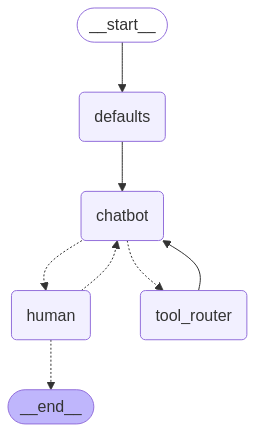

In [146]:
agent = SchemaFillingAgent(schema, config=AGENT_CONFIG)
agent.compile(graph_builder)
agent.visualize()

In [147]:
# The below line can convert a row dataframe to a JSON-like dict that can be passed into the model

# initial_json = json.loads(incomplete_df.to_json(orient="index"))

# response_state = agent.invoke({"current_json": initial_json})

# Extract the completed ow dataframe from the output json

# columns = [f["name"] for f in agent.get_schema()["fields"]]
# filled_df = pd.DataFrame([response_state["current_json"]], columns=columns)
# if 'index' in filled_df:
#     row_df = filled_df.drop('index', axis=1)

# Together, that gives us the below
def complete_missing_data_with_agent(incomplete_df: pd.DataFrame, agent: SchemaFillingAgent) -> pd.DataFrame:
    """
    Use an LLM Agent to fill in missing values in the incomplete dataset.

    Args:
        incomplete_df (pd.DataFrame): The incomplete DataFrame with missing values.
        temperature (float): The temperature setting for the LLM (default is 0.2).

    Returns:
        pd.DataFrame: A DataFrame with missing values filled in.
    """
    # Convert the incomplete DataFrame to a JSON dict for the agent.
    if isinstance(incomplete_df, pd.DataFrame):
        # First convert to Series
        incomplete_df = incomplete_df.iloc[0]
    initial_json = json.loads(incomplete_df.to_json(orient="index"))
    
    # Generate content using the LLM
    response_state = agent.invoke({"current_json": initial_json})
    
    # Extract the row dataframe from the output json
    columns = [f["name"] for f in agent.get_schema()["fields"]]
    row_df = pd.DataFrame([response_state["current_json"]], columns=columns)
    if 'index' in row_df:
        row_df = row_df.drop('index', axis=1)

    return row_df

The below cells are a toy example of using the agent to finish an incomplete tax form.\
They won't run on commit, so *uncomment* the following cells and run them to try it out.

In [148]:
# Toy example
data = {
    "filing_status": ["head_of_household"],
    "student_loan_interest": [1082],
    "mortgage_interest": [5393],
    "charitable_donations": [1478]}

toy_example = pd.DataFrame(data)

In [150]:
# Uncomment below to converse with the agent

# completed_example = complete_missing_data_with_agent(toy_example, agent)
# print("\nDataFrame from agent output:")
# print(completed_example)

# # Some final edits for conformity
# completed_example['income'] = completed_example['income'].astype(float)
# completed_example['student_loan_interest'] = completed_example['student_loan_interest'].astype(float)
# completed_example['mortgage_interest'] = completed_example['mortgage_interest'].astype(float)
# completed_example['charitable_donations'] = completed_example['charitable_donations'].astype(float)
# completed_example['dependents'] = completed_example['dependents'].astype(int)

# # Get a tax estimate and put it in the result
# completed_example[["predicted_tax", "refund"]] = completed_example.apply(estimate_tax, axis=1)
# print("\nDataFrame after predicting tax:")
# print(completed_example)

## Module 4 Incomplete Data Generation and Filling.
### Demonstrates **Structured Output** and **Generative AI Evaluation**

In [151]:
from pprint import pprint
import io
import matplotlib.pyplot as plt

Load the csv or xlsx file from the provided path.

In [152]:
def load_dataset(file_path: str) -> pd.DataFrame:
    """
    Load the dataset from an Excel or CSV file and return it as a DataFrame.
    """
    # Read the file into a DataFrame
    if file_path.endswith(".xlsx"):
        df = pd.read_excel(file_path)
    elif file_path.endswith(".csv"):
        df = pd.read_csv(file_path)
    else:
        raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")

    return df

# synthetic_tax_data_complete = load_dataset("/kaggle/input/synthetic-tax-data-complete/synthetic_tax_data.csv")
synthetic_tax_data_complete = generate_tax_dataset(n=4)
synthetic_tax_data_complete[["predicted_tax", "refund"]] = synthetic_tax_data_complete.apply(estimate_tax, axis=1)
synthetic_tax_data_complete.head()

,filing_status,income,student_loan_interest,mortgage_interest,charitable_donations,dependents,predicted_tax,refund
0,head_of_household,97689.01,1377.75,846.17,4855.11,0,13497.24,0.0
1,single,139717.81,1001.13,10829.98,960.98,1,21250.19,0.0
2,head_of_household,56009.09,428.60,14078.29,945.86,1,2634.64,0.0
3,head_of_household,76906.15,1952.67,11.68,7.09,0,8925.01,0.0


The function below generates incomplete rows from the complete dataset. It will modify an arbitrary column in the dataset and set it to "--"

In [153]:
def generate_incomplete_rows(df: pd.DataFrame, temperature: float = 0.2) -> pd.DataFrame:
    """
    Generate incomplete rows based on the given DataFrame using Google LLM.

    Args:
        df (pd.DataFrame): The input DataFrame.
        temperature (float): The temperature setting for the LLM (default is 0.2).

    Returns:
        pd.DataFrame: A DataFrame containing synthetic incomplete rows.

    Raises:
        ValueError: If the LLM response is empty or invalid.
    """
    # Convert a sample of the DataFrame to a tab-separated string for LLM input
    dataset_sample = df.to_csv(sep="\t", index=False).strip()

    # Define the request prompt
    prompt = (
        f"The dataset has the following format:\n\n{dataset_sample}\n\n"
        "Modify this dataset above by removing some fields from it randomly."
        "Introduce one or more missing fields in each row by replacing random values with --. Output only the tab-separated data, without any explanations or code."
        "Also, use row 1 as the title of each column, same as in dataset_sample."
    )

    # Set the temperature for the LLM
    config = types.GenerateContentConfig(temperature=temperature)

    # Generate content using the LLM
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=config,
        contents=[prompt],
    )

    # Check if the response is valid
    if not response.text.strip():
        raise ValueError("The LLM response is empty or invalid.")

    # Convert the LLM response (tab-separated string) back to a DataFrame
    incomplete_rows_df = pd.read_csv(io.StringIO(response.text), sep="\t")

    return incomplete_rows_df

synthetic_tax_data_incomplete = generate_incomplete_rows(synthetic_tax_data_complete)
print(synthetic_tax_data_incomplete)

       filing_status     income student_loan_interest  mortgage_interest  \
0  head_of_household   97689.01                    --             846.17   
1             single  139717.81               1001.13           10829.98   
2  head_of_household   56009.09                 428.6           14078.29   
3  head_of_household         --               1952.67              11.68   

  charitable_donations dependents  predicted_tax  refund  
0              4855.11          0       13497.24     0.0  
1                   --          1       21250.19     0.0  
2               945.86         --        2634.64     0.0  
3                 7.09          0        8925.01     0.0  


This function is used for getting detailed assessments on synthetic data generated by the LLM.

In [154]:
def assess_synthetic_data_performance(original_df: pd.DataFrame, synthetic_df: pd.DataFrame) -> dict:
    """
    Assess the performance of synthetic data by comparing it to the original data.

    Args:
        original_df (pd.DataFrame): The original DataFrame.
        synthetic_df (pd.DataFrame): The synthetic DataFrame.

    Returns:
        dict: A dictionary containing performance metrics and statistics.
    """
    # Replace missing values (e.g., '--') with NaN in the synthetic DataFrame
    synthetic_df = synthetic_df.replace('--', np.nan)

    # Ensure numeric columns are converted to the appropriate data type
    for col in original_df.select_dtypes(include=[np.number]).columns:
        synthetic_df[col] = pd.to_numeric(synthetic_df[col], errors='coerce')

    # Initialize metrics dictionary
    metrics = {}

    # 1. Missing Value Statistics
    metrics["missing_values"] = {
        "original": original_df.isna().sum().to_dict(),
        "synthetic": synthetic_df.isna().sum().to_dict(),
    }

    # 2. Data Type Consistency
    metrics["data_type_consistency"] = {
        col: {
            "original_dtype": str(original_df[col].dtype),
            "synthetic_dtype": str(synthetic_df[col].dtype),
            "consistent": original_df[col].dtype == synthetic_df[col].dtype,
        }
        for col in original_df.columns if col in synthetic_df.columns
    }

    # 3. Range Violations for Numeric Columns
    range_violations = {}
    for col in original_df.columns:
        if col in synthetic_df.columns and pd.api.types.is_numeric_dtype(original_df[col]):
            original_min, original_max = original_df[col].min(), original_df[col].max()
            synthetic_min, synthetic_max = synthetic_df[col].min(), synthetic_df[col].max()

            # Skip comparison if synthetic column contains only NaN
            if pd.notna(synthetic_min) and pd.notna(synthetic_max):
                if synthetic_min < original_min or synthetic_max > original_max:
                    range_violations[col] = {
                        "original_range": (original_min, original_max),
                        "synthetic_range": (synthetic_min, synthetic_max),
                    }
    metrics["range_violations"] = range_violations

    # 4. Summary Statistics for Numeric Columns
    numeric_summary = {}
    for col in original_df.select_dtypes(include=[np.number]).columns:
        if col in synthetic_df.columns:
            numeric_summary[col] = {
                "original": original_df[col].describe().to_dict(),
                "synthetic": synthetic_df[col].describe().to_dict(),
            }
    metrics["numeric_summary"] = numeric_summary

    # 5. Categorical Column Analysis
    categorical_analysis = {}
    for col in original_df.select_dtypes(exclude=[np.number]).columns:
        if col in synthetic_df.columns:
            original_unique = original_df[col].dropna().unique()
            synthetic_unique = synthetic_df[col].dropna().unique()
            categorical_analysis[col] = {
                "original_unique_values": len(original_unique),
                "synthetic_unique_values": len(synthetic_unique),
                "overlap": len(set(original_unique) & set(synthetic_unique)),
                "synthetic_only_values": list(set(synthetic_unique) - set(original_unique)),
            }
    metrics["categorical_analysis"] = categorical_analysis

    return metrics

original = synthetic_tax_data_complete
generated = synthetic_tax_data_incomplete
performance_metrics = assess_synthetic_data_performance(original, generated)
pprint(performance_metrics)

{'categorical_analysis': {'filing_status': {'original_unique_values': 2,
                                            'overlap': 2,
                                            'synthetic_only_values': [],
                                            'synthetic_unique_values': 2}},
 'data_type_consistency': {'charitable_donations': {'consistent': True,
                                                    'original_dtype': 'float64',
                                                    'synthetic_dtype': 'float64'},
                           'dependents': {'consistent': False,
                                          'original_dtype': 'int64',
                                          'synthetic_dtype': 'float64'},
                           'filing_status': {'consistent': True,
                                             'original_dtype': 'object',
                                             'synthetic_dtype': 'object'},
                           'income': {'consistent': True,
        

The code below uses an LLM agent for filling in missing data from the incomplete dataset

In [155]:
def complete_missing_data(incomplete_df: pd.DataFrame, temperature: float = 0.2) -> pd.DataFrame:
    """
    Use an LLM to fill in missing values in the incomplete dataset.

    Args:
        incomplete_df (pd.DataFrame): The incomplete DataFrame with missing values.
        temperature (float): The temperature setting for the LLM (default is 0.2).

    Returns:
        pd.DataFrame: A DataFrame with missing values filled in.
    """
    # Convert the incomplete DataFrame to a tab-separated string for LLM input
    dataset_sample = incomplete_df.to_csv(sep="\t", index=False).strip()

    # Define the request prompt
    prompt = (
        f"The dataset has the following tab-separated format with missing values indicated as '--':\n\n{dataset_sample}\n\n"
        "Complete the dataset by filling in the missing values ('--') with plausible values. "
        "Ensure the structure and data types are preserved. Return the result as a tab-separated plain text dataset, without any explanations or code."
    )

    # Set the temperature for the LLM
    config = types.GenerateContentConfig(temperature=temperature)

    # Generate content using the LLM
    response = client.models.generate_content(
        model="gemini-2.0-flash",  
        config=config,
        contents=[prompt],
    )

    # Check if the response is valid
    if not response.text.strip():
        raise ValueError("The LLM response is empty or invalid.")

    # Convert the LLM response back to a DataFrame
    filled_df = pd.read_csv(io.StringIO(response.text), sep="\t")

    return filled_df

completed_data = complete_missing_data(generated)
print(completed_data)

       filing_status     income  student_loan_interest  mortgage_interest  \
0  head_of_household   97689.01                 500.00             846.17   
1             single  139717.81                1001.13           10829.98   
2  head_of_household   56009.09                 428.60           14078.29   
3  head_of_household   60000.00                1952.67              11.68   

   charitable_donations  dependents  predicted_tax  refund  
0               4855.11           0       13497.24     0.0  
1               1000.00           1       21250.19     0.0  
2                945.86           0        2634.64     0.0  
3                  7.09           0        8925.01     0.0  


The code below plots the mean and standard deviation for corresponding columns in the DataFrames provided

In [156]:
def visualize_statistics(original_df: pd.DataFrame, filled_df: pd.DataFrame):
    """
    Visualize statistics to assess the performance of the completion model.

    Args:
        original_df (pd.DataFrame): The original complete DataFrame.
        filled_df (pd.DataFrame): The filled DataFrame (after LLM interpretation).
    """
    # Replace '--' with NaN in the filled DataFrame
    filled_df = filled_df.replace('--', np.nan)

    # Ensure numeric columns are converted to appropriate numeric types
    for col in original_df.select_dtypes(include=[np.number]).columns:
        filled_df[col] = pd.to_numeric(filled_df[col], errors='coerce')

    # Compute descriptive statistics for numeric columns
    stats_original = original_df.describe().transpose()
    stats_filled = filled_df.describe().transpose()

    # Combine only the required statistics into a single DataFrame
    combined_stats = pd.DataFrame({
        "original_mean": stats_original["mean"],
        "filled_mean": stats_filled["mean"],
        "original_std": stats_original["std"],
        "filled_std": stats_filled["std"],
    })

    # Display the combined statistics as a table
    print("\nDescriptive Statistics Comparison:")
    print(combined_stats)

    # Compare standard deviations
    std_df = combined_stats[["original_std", "filled_std"]]
    std_df.plot(kind="bar", figsize=(12, 6))
    plt.title("Comparison of Standard Deviations")
    plt.ylabel("Standard Deviation")
    plt.xlabel("Columns")
    plt.legend(title="Dataset")
    plt.show()

    # Compare means
    mean_df = combined_stats[["original_mean", "filled_mean"]]
    mean_df.plot(kind="bar", figsize=(12, 6), color=["blue", "orange"])
    plt.title("Comparison of Means")
    plt.ylabel("Mean")
    plt.xlabel("Columns")
    plt.legend(title="Dataset")
    plt.show()

Below is the main algorithm for testing the performance of the LLM. It involves generating incomplete rows using one LLM, then using another LLM to fill in the incomplete rows, and finally visualizing the mean and standard deviation between the original and predicted results.

In [157]:
def main_pipeline(original_df: pd.DataFrame):
    # Step 1: Generate incomplete data using the first LLM
    incomplete_df = generate_incomplete_rows(original_df, temperature=0.2)

    # Step 2: Fill in missing values using the second LLM
    filled_df = complete_missing_data(incomplete_df, temperature=0.2)

    # Step 3: Visualize and analyze performance
    visualize_statistics(original_df, filled_df)

    # Optionally, return the data for further use
    return {"original": original_df, "incomplete": incomplete_df, "filled": filled_df}


Descriptive Statistics Comparison:
                       original_mean  filled_mean  original_std    filled_std
income                    92580.5150    92580.515  35735.958295  35735.958295
student_loan_interest      1190.0375      970.600    640.915341    702.524478
mortgage_interest          6441.5300     7688.610   7076.477967   5908.858459
charitable_donations       1692.2600     1702.015   2155.249518   2150.920290
dependents                    0.5000        0.500      0.577350      0.577350
predicted_tax             11576.7700    12668.110   7837.022810   6337.134533
refund                        0.0000        0.000      0.000000      0.000000


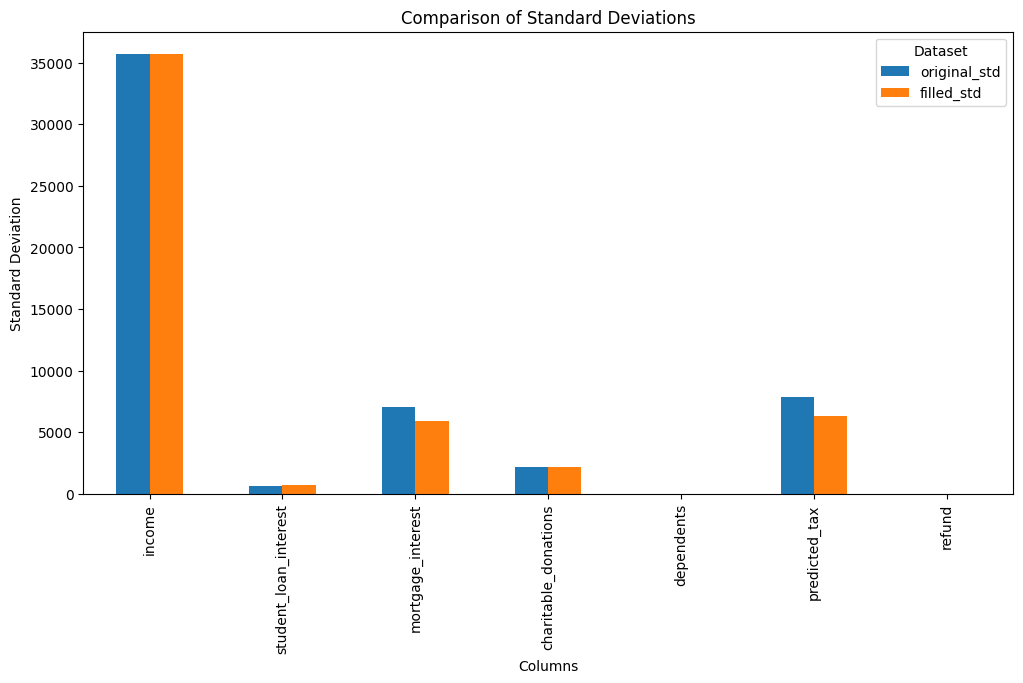

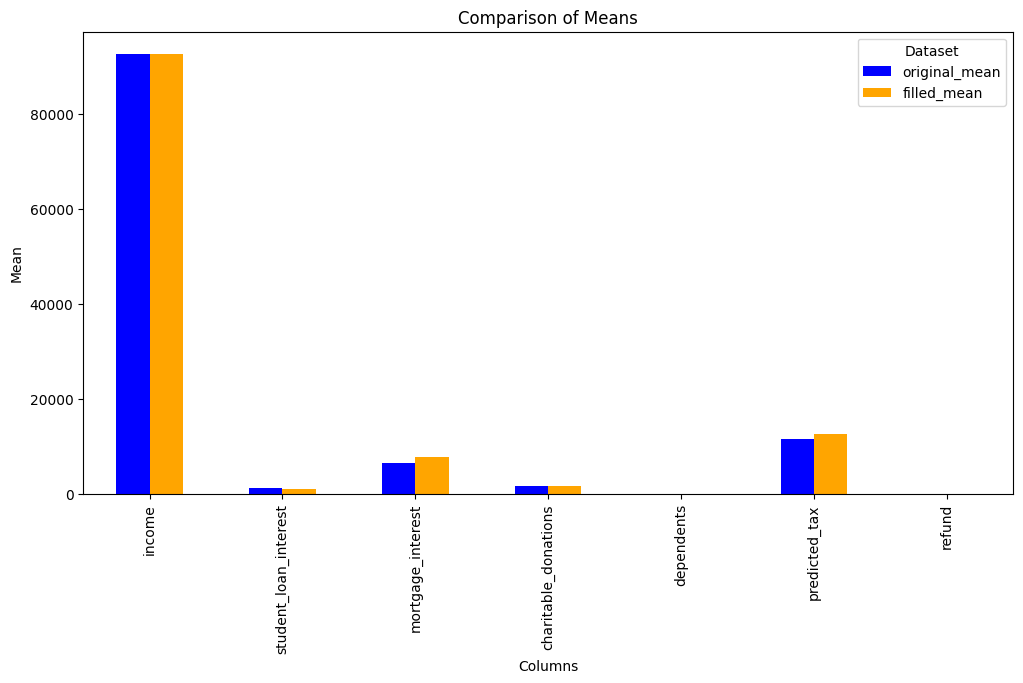

In [158]:
hash_map = main_pipeline(synthetic_tax_data_complete)